In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch import nn
import os

# Download dữ liệu
!gdown 1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
!unzip ./flower_photos.zip

# Load dữ liệu
data_path = "./flower_photos"
dataset = ImageFolder(root=data_path)

# Lấy thông tin cơ bản
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

# Chia dữ liệu thành tập train, validation và test
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1
n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_valid_examples

train_dataset, valid_dataset, test_dataset = random_split(
    dataset,
    [n_train_examples, n_valid_examples, n_test_examples]
)


Downloading...
From (original): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
From (redirected): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc&confirm=t&uuid=8a22ab3d-6d13-40ee-b033-834f4d68978c
To: /content/flower_photos.zip
100% 230M/230M [00:02<00:00, 89.9MB/s]
Archive:  ./flower_photos.zip
   creating: flower_photos/
   creating: flower_photos/daisy/
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower_photos/daisy/104377705

In [2]:
# Kích thước ảnh đầu vào
IMG_SIZE = 224

# Các phép biến đổi cho tập train
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),       # Thay đổi kích thước ảnh
    transforms.RandomHorizontalFlip(),            # Lật ngẫu nhiên ảnh theo chiều ngang
    transforms.RandomRotation(0.2),               # Xoay ngẫu nhiên ảnh trong khoảng ±20 độ
    transforms.ToTensor(),                         # Chuyển đổi ảnh sang tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Chuẩn hóa giá trị ảnh
])

# Các phép biến đổi cho tập validation và test
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Áp dụng phép biến đổi cho các tập dữ liệu
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms


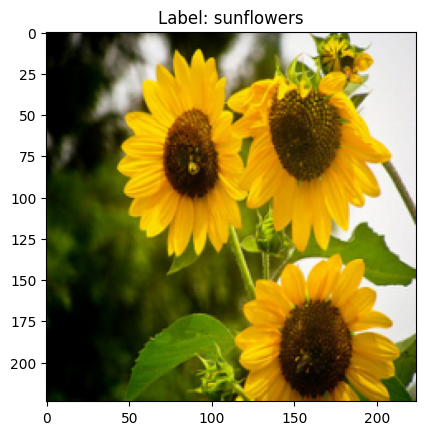

In [3]:
from matplotlib import pyplot as plt

# Lấy một mẫu từ train_dataset
sample_img, sample_label = train_dataset[0]

# Chuyển đổi từ tensor sang ảnh
img = sample_img.permute(1, 2, 0).numpy()
img = (img * 0.5) + 0.5  # Hoàn nguyên chuẩn hóa về [0, 1]

# Hiển thị ảnh
plt.imshow(img)
plt.title(f"Label: {classes[sample_label]}")
plt.show()


In [4]:
from torch.utils.data import DataLoader

# Kích thước batch
BATCH_SIZE = 512

# DataLoader cho tập train
train_loader = DataLoader(
    train_dataset,
    shuffle=True,  # Xáo trộn dữ liệu trong mỗi epoch
    batch_size=BATCH_SIZE
)

# DataLoader cho tập validation
val_loader = DataLoader(
    valid_dataset,
    shuffle=False,  # Không cần xáo trộn tập validation
    batch_size=BATCH_SIZE
)

# DataLoader cho tập test
test_loader = DataLoader(
    test_dataset,
    shuffle=False,  # Không cần xáo trộn tập test
    batch_size=BATCH_SIZE
)


In [5]:
# Lấy một batch từ train_loader
for images, labels in train_loader:
    print(f"Batch size: {images.size(0)}")  # Số lượng mẫu trong batch
    print(f"Image shape: {images.shape}")  # Kích thước của ảnh (batch_size, channels, height, width)
    print(f"Labels: {labels[:5]}")  # In 5 nhãn đầu tiên
    break


Batch size: 512
Image shape: torch.Size([512, 3, 224, 224])
Labels: tensor([1, 0, 2, 4, 4])


In [6]:
import torch
import torch.nn as nn

# Transformer Encoder Block
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

# Patch and Position Embedding
class PatchPositionEmbedding(nn.Module):
    def __init__(self, image_size=224, embed_dim=512, patch_size=16, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        scale = embed_dim ** -0.5
        self.positional_embedding = nn.Parameter(scale * torch.randn((image_size // patch_size) ** 2, embed_dim))
        self.device = device

    def forward(self, x):
        x = self.conv1(x)  # shape: [*, embed_dim, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape: [*, embed_dim, grid^2]
        x = x.permute(0, 2, 1)  # shape: [*, grid^2, embed_dim]
        x = x + self.positional_embedding.to(self.device)
        return x

# Vision Transformer Model
class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim, dropout=0.1, device='cpu', num_classes=10, patch_size=16):
        super().__init__()
        self.embd_layer = PatchPositionEmbedding(
            image_size=image_size, embed_dim=embed_dim, patch_size=patch_size, device=device
        )
        self.transformer_layer = TransformerEncoder(
            embed_dim, num_heads, ff_dim, dropout
        )
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = output[:, 0, :]  # Lấy embedding của token đầu tiên
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output


In [7]:
# Cấu hình huấn luyện
image_size = 224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout = 0.1
num_classes = len(classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VisionTransformerCls(
    image_size=image_size, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim,
    dropout=dropout, num_classes=num_classes, device=device
)
model.to(device)

# Định nghĩa hàm mất mát và tối ưu hóa
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Số epoch và đường dẫn lưu mô hình
num_epochs = 100
save_model = './vit_flowers'
os.makedirs(save_model, exist_ok=True)
model_name = 'vit_flowers'

# Huấn luyện mô hình
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        # Print kết quả epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Lưu mô hình tốt nhất
        torch.save(model.state_dict(), os.path.join(save_model, f"{model_name}_epoch{epoch + 1}.pth"))

# Gọi hàm huấn luyện
train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)


Epoch [1/100] Train Loss: 10.8347, Train Acc: 0.2698 Val Loss: 1.5626, Val Acc: 0.2698
Epoch [2/100] Train Loss: 8.6212, Train Acc: 0.3685 Val Loss: 1.3702, Val Acc: 0.3896
Epoch [3/100] Train Loss: 8.1833, Train Acc: 0.3893 Val Loss: 1.3476, Val Acc: 0.4278
Epoch [4/100] Train Loss: 7.7562, Train Acc: 0.4448 Val Loss: 1.3323, Val Acc: 0.3896
Epoch [5/100] Train Loss: 7.5094, Train Acc: 0.4550 Val Loss: 1.2793, Val Acc: 0.4142
Epoch [6/100] Train Loss: 7.2937, Train Acc: 0.4724 Val Loss: 1.2533, Val Acc: 0.4169
Epoch [7/100] Train Loss: 7.1204, Train Acc: 0.4983 Val Loss: 1.2289, Val Acc: 0.4441
Epoch [8/100] Train Loss: 6.9205, Train Acc: 0.5187 Val Loss: 1.2030, Val Acc: 0.4441
Epoch [9/100] Train Loss: 6.8585, Train Acc: 0.5112 Val Loss: 1.1977, Val Acc: 0.4714
Epoch [10/100] Train Loss: 6.7307, Train Acc: 0.5198 Val Loss: 1.1668, Val Acc: 0.4905
Epoch [11/100] Train Loss: 6.5934, Train Acc: 0.5310 Val Loss: 1.1351, Val Acc: 0.5095
Epoch [12/100] Train Loss: 6.4742, Train Acc: 0.548

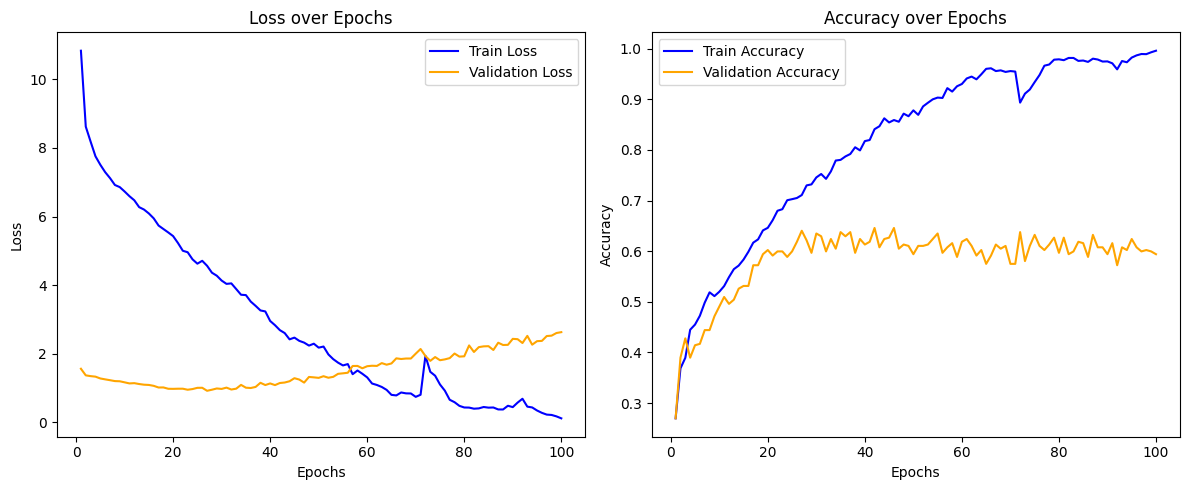

In [12]:
import matplotlib.pyplot as plt

# Dữ liệu từ quá trình huấn luyện
epochs = range(1, 101)
train_losses = [
    10.8347, 8.6212, 8.1833, 7.7562, 7.5094, 7.2937, 7.1204, 6.9205, 6.8585, 6.7307,
    6.5934, 6.4742, 6.2744, 6.2038, 6.0901, 5.9475, 5.7380, 5.6366, 5.5363, 5.4301,
    5.2287, 5.0027, 4.9595, 4.7525, 4.6259, 4.7098, 4.5645, 4.3629, 4.2751, 4.1336,
    4.0373, 4.0512, 3.8869, 3.7203, 3.7100, 3.5208, 3.3963, 3.2627, 3.2340, 2.9558,
    2.8321, 2.6883, 2.6024, 2.4199, 2.4705, 2.3761, 2.3246, 2.2377, 2.2931, 2.1778,
    2.2103, 1.9799, 1.8427, 1.7400, 1.6593, 1.6990, 1.4040, 1.5119, 1.4164, 1.3103,
    1.1320, 1.0894, 1.0318, 0.9469, 0.8013, 0.7851, 0.8710, 0.8451, 0.8418, 0.7435,
    0.8047, 1.9393, 1.4734, 1.3593, 1.1042, 0.9240, 0.6587, 0.5875, 0.4809, 0.4335,
    0.4306, 0.3982, 0.4071, 0.4474, 0.4288, 0.4333, 0.3766, 0.3752, 0.4840, 0.4442,
    0.5762, 0.6879, 0.4582, 0.4349, 0.3459, 0.2772, 0.2260, 0.2159, 0.1744, 0.1170
]
val_losses = [
    1.5626, 1.3702, 1.3476, 1.3323, 1.2793, 1.2533, 1.2289, 1.2030, 1.1977, 1.1668,
    1.1351, 1.1430, 1.1173, 1.0980, 1.0907, 1.0646, 1.0162, 1.0180, 0.9791, 0.9766,
    0.9807, 0.9809, 0.9510, 0.9706, 1.0064, 1.0082, 0.9201, 0.9515, 0.9878, 0.9749,
    1.0126, 0.9572, 0.9819, 1.0926, 1.0105, 1.0011, 1.0327, 1.1535, 1.0876, 1.1347,
    1.0862, 1.1469, 1.1614, 1.1984, 1.2874, 1.2478, 1.1590, 1.3238, 1.3117, 1.2970,
    1.3455, 1.3007, 1.3269, 1.4150, 1.4294, 1.4461, 1.6431, 1.6451, 1.5763, 1.6367,
    1.6504, 1.6453, 1.7273, 1.6809, 1.7177, 1.8661, 1.8471, 1.8607, 1.8612, 2.0026,
    2.1386, 1.9338, 1.7925, 1.9036, 1.8114, 1.8358, 1.8726, 2.0063, 1.9166, 1.9256,
    2.2426, 2.0515, 2.1932, 2.2155, 2.2207, 2.1098, 2.3216, 2.2554, 2.2599, 2.4343,
    2.4247, 2.3128, 2.5211, 2.2644, 2.3668, 2.3748, 2.5162, 2.5277, 2.6047, 2.6296
]
train_accuracies = [
    0.2698, 0.3685, 0.3893, 0.4448, 0.4550, 0.4724, 0.4983, 0.5187, 0.5112, 0.5198,
    0.5310, 0.5487, 0.5644, 0.5715, 0.5834, 0.5988, 0.6168, 0.6233, 0.6410, 0.6461,
    0.6611, 0.6798, 0.6829, 0.7006, 0.7027, 0.7050, 0.7108, 0.7299, 0.7319, 0.7456,
    0.7524, 0.7428, 0.7575, 0.7790, 0.7803, 0.7871, 0.7919, 0.8052, 0.7990, 0.8174,
    0.8195, 0.8409, 0.8467, 0.8624, 0.8542, 0.8590, 0.8556, 0.8716, 0.8665, 0.8781,
    0.8692, 0.8859, 0.8931, 0.8999, 0.9033, 0.9026, 0.9220, 0.9152, 0.9257, 0.9302,
    0.9411, 0.9448, 0.9394, 0.9493, 0.9601, 0.9612, 0.9557, 0.9571, 0.9540, 0.9557,
    0.9547, 0.8934, 0.9111, 0.9193, 0.9339, 0.9479, 0.9663, 0.9687, 0.9782, 0.9789,
    0.9772, 0.9816, 0.9816, 0.9758, 0.9765, 0.9738, 0.9802, 0.9785, 0.9745, 0.9748,
    0.9710, 0.9591, 0.9755, 0.9731, 0.9823, 0.9867, 0.9894, 0.9891, 0.9928, 0.9959
]
val_accuracies = [
    0.2698, 0.3896, 0.4278, 0.3896, 0.4142, 0.4169, 0.4441, 0.4441, 0.4714, 0.4905,
    0.5095, 0.4959, 0.5041, 0.5259, 0.5313, 0.5313, 0.5722, 0.5722, 0.5940, 0.6022,
    0.5913, 0.5995, 0.5995, 0.5886, 0.5995, 0.6185, 0.6403, 0.6213, 0.5967, 0.6349,
    0.6294, 0.5995, 0.6240, 0.6049, 0.6376, 0.6294, 0.6376, 0.5967, 0.6240, 0.6131,
    0.6185, 0.6458, 0.6076, 0.6240, 0.6267, 0.6458, 0.6049, 0.6131, 0.6104, 0.5940,
    0.6104, 0.6104, 0.6131, 0.6240, 0.6349, 0.5967, 0.6076, 0.6158, 0.5886, 0.6185,
    0.6240, 0.6104, 0.5913, 0.6022, 0.5749, 0.5913, 0.6131, 0.6049, 0.6104, 0.5749,
    0.5749, 0.6376, 0.5804, 0.6104, 0.6322, 0.6104, 0.6022, 0.6131, 0.6267, 0.5967,
    0.6267, 0.5940, 0.5995, 0.6185, 0.6158, 0.5886, 0.6322, 0.6076, 0.6076, 0.5940,
    0.6158, 0.5722, 0.6076, 0.6022, 0.6240, 0.6076, 0.5995, 0.6022, 0.5995, 0.5940
]

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color='blue')
plt.plot(epochs, val_losses, label="Validation Loss", color='orange')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Vẽ biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", color='blue')
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()



In [14]:
from transformers import ViTForImageClassification

# Mapping giữa id và label
id2label = {id: label for id, label in enumerate(classes)}
label2id = {label: id for id, label in id2label.items()}

# Tải mô hình ViT cho bài toán phân loại
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',  # Mô hình ViT pretrained
    num_labels=num_classes,  # Số nhãn
    id2label=id2label,  # Mapping từ id sang label
    label2id=label2id   # Mapping từ label sang id
)

# Sử dụng GPU nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [16]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [17]:
import evaluate
import numpy as np

# Tải metric "accuracy" từ thư viện evaluate
metric = evaluate.load("accuracy")

# Hàm tính toán chỉ số đánh giá
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)  # Lấy nhãn dự đoán có xác suất cao nhất
    return metric.compute(predictions=predictions, references=labels)


In [18]:
import torch
from transformers import ViTImageProcessor, TrainingArguments, Trainer

# Khởi tạo feature extractor cho ViT
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Tên metric để đánh giá
metric_name = "accuracy"

# Thiết lập tham số huấn luyện
args = TrainingArguments(
    output_dir="vit_flowers",  # Thư mục lưu kết quả
    save_strategy="epoch",  # Lưu mô hình sau mỗi epoch
    evaluation_strategy="epoch",  # Đánh giá trên tập validation sau mỗi epoch
    learning_rate=2e-5,  # Tốc độ học
    per_device_train_batch_size=32,  # Batch size cho train
    per_device_eval_batch_size=32,  # Batch size cho eval
    num_train_epochs=10,  # Số epoch
    weight_decay=0.01,  # Trọng số weight decay
    load_best_model_at_end=True,  # Tải mô hình tốt nhất sau huấn luyện
    metric_for_best_model=metric_name,  # Chọn mô hình tốt nhất dựa trên metric
    logging_dir='logs',  # Thư mục lưu log
    remove_unused_columns=False,  # Giữ các cột không sử dụng trong dataset
)

# Hàm collate để xử lý batch dữ liệu
def collate_fn(examples):
    # example => Tuple (image, label)
    pixel_values = torch.stack([example[0] for example in examples])  # Stack pixel_values
    labels = torch.tensor([example[1] for example in examples])  # Tensor hóa labels
    return {"pixel_values": pixel_values, "labels": labels}

# Khởi tạo Trainer
trainer = Trainer(
    model=model,  # Mô hình ViT đã khởi tạo
    args=args,  # Tham số huấn luyện
    train_dataset=train_dataset,  # Tập train
    eval_dataset=valid_dataset,  # Tập validation
    data_collator=collate_fn,  # Hàm collate để chuẩn bị batch
    compute_metrics=compute_metrics,  # Hàm tính metric
    tokenizer=feature_extractor,  # Feature extractor cho hình ảnh
)


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-18-54395ec6c37d>:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
# Huấn luyện mô hình
trainer.train()

# Dự đoán trên tập test
outputs = trainer.predict(test_dataset)

# In các chỉ số đánh giá
print(outputs.metrics)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.564151,0.950954
2,No log,0.287238,0.964578
3,No log,0.212567,0.972752
4,No log,0.187689,0.967302
5,No log,0.175124,0.967302
6,0.329000,0.167933,0.967302
7,0.329000,0.165469,0.964578
8,0.329000,0.163704,0.964578
9,0.329000,0.162617,0.964578
10,0.329000,0.162399,0.964578


{'test_loss': 0.19551897048950195, 'test_accuracy': 0.9673024523160763, 'test_runtime': 5.2655, 'test_samples_per_second': 69.699, 'test_steps_per_second': 2.279}


In [20]:
trainer.save_model("vit_best_model")
